# Cloudy With a Chance of Data

### Acquiring Weather Data from an API

In [2]:
cities = {"Chicago": '41.837551,-87.681844',
       	  "Boston": '42.331960,-71.020173',
          "Austin": '30.303936,-97.754355',
          "Washington": '38.904103,-77.017229',
          "Denver": '39.761850,-104.881105'}

api_key = '93760ce40fe2a1964816cf21468b799c'


###### Look at what is received when make api call to forecast.io API

In [3]:
import datetime
import requests
url = 'https://api.forecast.io/forecast/'
current_time = datetime.datetime.now().strftime("%s")
api_call = url + api_key + '/' + cities['Chicago'] + ',' + current_time

r = requests.get(api_call)
r.json()['daily']['data'][0]

{u'apparentTemperatureMax': 86.37,
 u'apparentTemperatureMaxTime': 1439928000,
 u'apparentTemperatureMin': 68.78,
 u'apparentTemperatureMinTime': 1439899200,
 u'cloudCover': 0.79,
 u'dewPoint': 69.08,
 u'humidity': 0.83,
 u'icon': u'rain',
 u'moonPhase': 0.13,
 u'ozone': 298.65,
 u'precipIntensity': 0.0253,
 u'precipIntensityMax': 0.2044,
 u'precipIntensityMaxTime': 1439892000,
 u'precipProbability': 0.78,
 u'precipType': u'rain',
 u'pressure': 1010.14,
 u'summary': u'Rain until afternoon, starting again in the evening.',
 u'sunriseTime': 1439895793,
 u'sunsetTime': 1439945335,
 u'temperatureMax': 82.39,
 u'temperatureMaxTime': 1439928000,
 u'temperatureMin': 68.78,
 u'temperatureMinTime': 1439899200,
 u'time': 1439874000,
 u'visibility': 6.98,
 u'windBearing': 169,
 u'windSpeed': 5.23}

### Script
Purpose of this is to get the max temperature for 5 specified cities each day for the past 30 days

In [53]:
import sqlite3 as lite

cities = {"Chicago": '41.837551,-87.681844',
          "Boston": '42.331960,-71.020173',
          "Austin": '30.303936,-97.754355',
          "Washington": '38.904103,-77.017229',
          "Denver": '39.761850,-104.881105'}

url = 'https://api.forecast.io/forecast/'
api_key = '93760ce40fe2a1964816cf21468b799c'

con = lite.connect('weather.db')
cur = con.cursor()

with con:
     cur.execute("""CREATE TABLE daily_temp (query_time INT, 
                                             Chicago REAL, 
                                             Boston REAL, 
                                             Austin REAL,
                                             Washington REAL, 
                                             Denver REAL);""")
        
for i in range(30, 0, -1):
    query_time = (datetime.datetime.now() - datetime.timedelta(days=i)).strftime('%s')
    with con:
        cur.execute("INSERT INTO daily_temp(query_time) VALUES (?)", (int(query_time),))
        
    for city, loc in cities.items():
        api_call = url + api_key + '/' + loc + ',' + query_time
    
        r = requests.get(api_call)
        max_temp = r.json()['daily']['data'][0]['temperatureMax']

        with con:
            cur.execute("UPDATE daily_temp SET " + city + " = " + str(max_temp) + " " +
                        "WHERE query_time = " + query_time)

con.close()

### Profiling Temperature Data

In [5]:
import sqlite3 as lite
import pandas as pd

con = lite.connect('weather.db')
cur = con.cursor()

df = pd.read_sql_query("SELECT * FROM daily_temp ORDER BY query_time",con,index_col='query_time')
df.head()

,Chicago,Boston,Austin,Washington,Denver
query_time,,,,,
1437277270,86.55,75.52,95.83,85.62,86.05
1437363671,82.82,87.62,96.48,93.98,79.45
1437450072,85.94,90.40,96.04,93.62,81.57
1437536473,77.14,80.77,96.74,88.69,78.11
1437622874,79.14,82.31,95.80,85.86,87.51


In [55]:
df.describe()

,Chicago,Boston,Austin,Washington,Denver
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,83.344667,81.285333,98.547333,87.076000,86.956333
std,4.153072,6.019743,2.209350,3.925591,4.164677
min,76.010000,68.140000,95.690000,75.600000,78.110000
25%,79.810000,77.692500,96.752500,85.590000,83.522500
50%,83.445000,82.065000,98.105000,87.425000,87.925000
75%,87.382500,85.972500,100.277500,89.415000,90.160000
max,91.100000,90.680000,103.600000,93.980000,93.070000


In [14]:
#Ranges
df[df.columns].max() - df[df.columns].min()

Chicago       15.09
Boston        22.54
Austin         7.91
Washington    18.38
Denver        14.96
dtype: float64

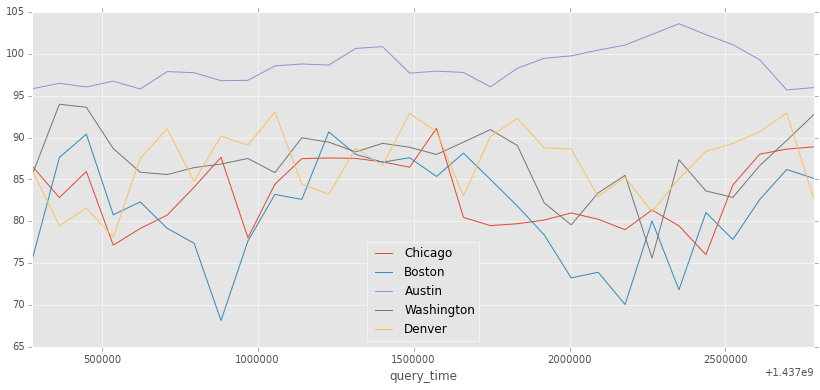

In [47]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

df.plot(figsize=(14,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc76c63da10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc76c6487d0>]], dtype=object)

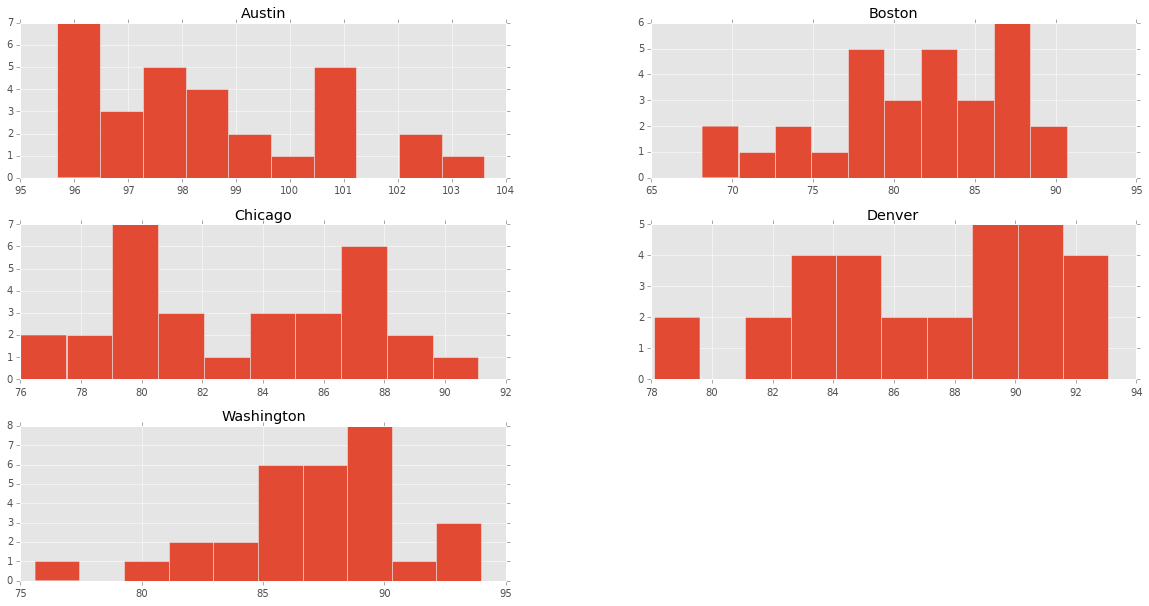

In [49]:
df.hist(figsize=(20,10))

##### Looking at changes in temperature over time for each city

In [52]:
change_df = pd.DataFrame(abs(df[1:].values-df[:-1]), columns=df.columns)
change_df.describe()

,Chicago,Boston,Austin,Washington,Denver
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,2.991724,4.574828,1.076552,2.925862,4.219655
std,3.038314,3.392516,0.919228,2.948728,2.697574
min,0.050000,0.530000,0.050000,0.280000,0.130000
25%,0.630000,2.240000,0.280000,0.830000,2.160000
50%,2.000000,3.230000,0.940000,1.900000,3.540000
75%,3.690000,8.070000,1.720000,3.800000,6.220000
max,10.640000,12.100000,3.600000,11.750000,10.190000


In [53]:
#Total change for each city
change_df[change_df.columns].sum()

Chicago        86.76
Boston        132.67
Austin         31.22
Washington     84.85
Denver        122.37
dtype: float64

In [54]:
#Ranges
change_df[change_df.columns].max() - change_df[change_df.columns].min()

Chicago       10.59
Boston        11.57
Austin         3.55
Washington    11.47
Denver        10.06
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7645afb90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc764056490>]], dtype=object)

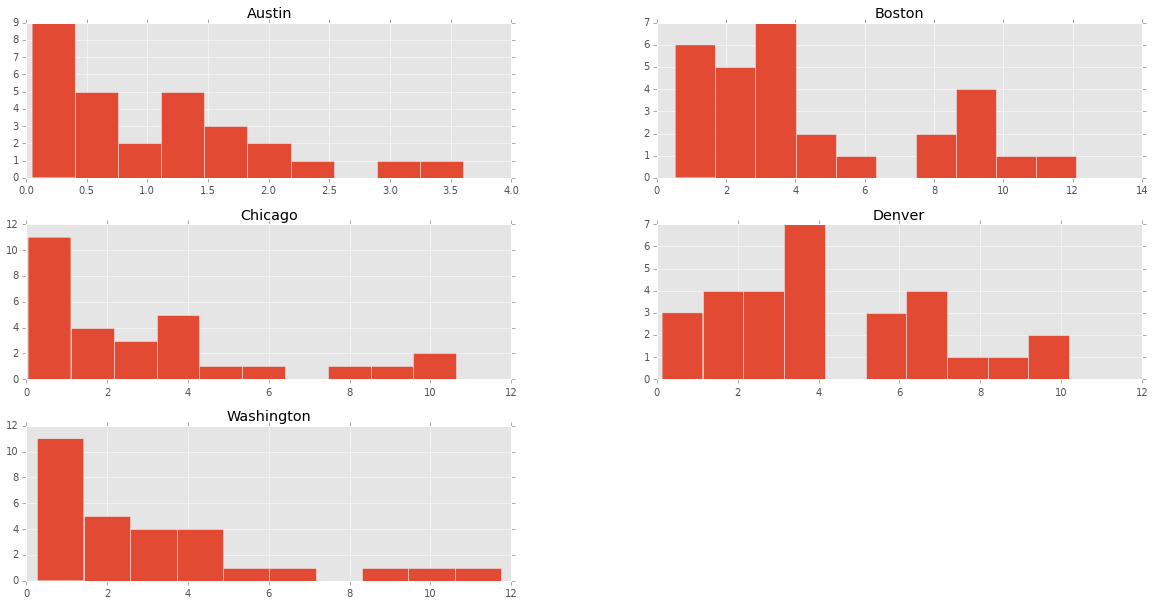

In [56]:
change_df.hist(figsize=(20,10))

### Conclusion

Overall, Boston had the highest range in temperatures (68.14F to 90.68F across the 30 day period), as well as the largest total fluctuation in temperature across the 30 day period. Boston also had the highest single day-to-day temperature change (11.57F), and the highest total change in day-to-day temperature across the 30 day period.

This result isn't all that surprising - as Mark Twain said, "If you don't like the weather in New England now, just wait a few minutes"